In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from joblib import Parallel, delayed

In [2]:
class MultiKernelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiKernelConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            self.branches.append(branch)

    def forward(self, x):
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv1 = MultiKernelConv2d(1, 3)
        self.conv2 = MultiKernelConv2d(9, 3)
        self.fc1 = nn.Linear(3 * 3 * (img_size // 4) * (img_size // 4), 2048)
        self.fc2 = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNWithMask, self).__init__()
        self.unet = CNN(n_channels, n_classes)
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.unet(x)
        logits = self.apply_mask(logits, x)
        return logits

model = CNNWithMask(150*150, 150)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

CNNWithMask(
  (unet): CNN(
    (conv1): MultiKernelConv2d(
      (branches): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, 

In [4]:
def process_file(file):
    X_tmp = pd.read_parquet(f'../data/{file}').to_numpy()
    random_idx = np.random.choice(X_tmp.shape[0]-1, 10, replace=False)
    y_tmp = X_tmp[random_idx + 1] - X_tmp[random_idx]
    X_tmp = X_tmp[random_idx].reshape(-1, 1, 150, 150)
    return X_tmp, y_tmp

filenames = os.listdir('../data')
filenames = [filename for filename in filenames if filename.endswith('.parquet')]

results = Parallel(n_jobs=-1, verbose=10)(delayed(process_file)(file) for file in filenames[:100])

X = []
y = []
for X_tmp, y_tmp in results:
    X.extend(X_tmp)
    y.extend(y_tmp)

X = np.array(X)
y = np.array(y)

random_idx = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[random_idx]
y = y[random_idx]

print(X.shape, y.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:   43.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.5s finished


(1000, 1, 150, 150) (1000, 22500)


In [5]:
model.train();

batch_size = 10
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]
    X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
    output = model(X_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

6.541650295257568
7.923562526702881
9.983251571655273
12.655173301696777
11.264143943786621
14.440765380859375
14.871817588806152
8.427680015563965
7.913281440734863
7.441107273101807
7.9971818923950195
6.628291606903076
7.158881664276123
7.262510776519775
6.339062690734863
6.741206645965576
5.2630181312561035
6.317514419555664
5.778409481048584
6.4324493408203125
5.7928924560546875
5.609959602355957
5.71000862121582
6.19830322265625
6.2358245849609375
6.085282802581787
6.065277576446533
6.703227519989014
6.393619060516357
5.347876071929932
5.960691928863525
6.1442341804504395
5.849876403808594
5.7145867347717285
5.803511142730713
5.6041579246521
5.857860565185547
5.861587047576904
6.384191036224365
5.810740947723389
6.459796905517578
5.54003381729126
6.049962520599365
6.518174171447754
6.316806316375732
5.3271660804748535
4.99998664855957
6.143891334533691
5.190523624420166
5.855653285980225
5.482844829559326
6.133236885070801
6.357264041900635
6.209381103515625
5.888651371002197
5.74

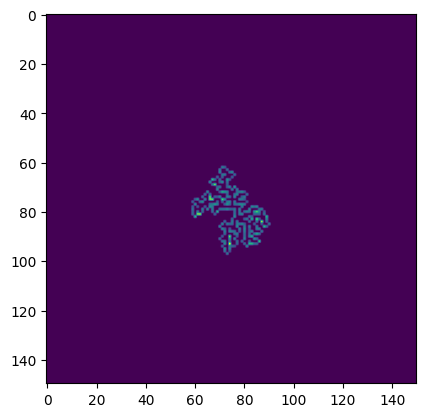

In [17]:
model.eval()
output = F.softmax(model(X_batch), dim=1)
output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(150, 150));